In [ ]:
import os
import glob
import sklearn
import pandas as pd
import numpy as np
import gdal
from google.colab import drive
from sklearn.model_selection import train_test_split
from sklearn import metrics 
drive.mount("/content/drive")
import matplotlib.pyplot as plt

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#read samples
train_file_noncrop = pd.read_csv("/content/drive/MyDrive/Senior Design/Competition /Samples/SR_samples/SriLanka_intensity/samples_intensity_SriLanka_noncropland.csv",index_col=False)
train_file_noncrop=train_file_noncrop.sample(n=350)

train_file_noncrop_water = pd.read_csv("/content/drive/MyDrive/Senior Design/Competition /Samples/SR_samples/SriLanka_intensity/samples_intensity_SriLanka_water (1).csv",index_col=False)
train_file_noncrop_water =train_file_noncrop_water.sample(n=100) #10% of noncropland
train_file_noncropland = pd.concat([train_file_noncrop_water,train_file_noncrop])

train_file_crop= pd.read_csv("/content/drive/MyDrive/Senior Design/Competition /Samples/SR_samples/SriLanka_intensity/samples_intensity_SriLanka_cropland.csv", index_col=False)


df_SR= pd.concat([train_file_noncropland,train_file_crop])
df_SR= df_SR.drop(["system:index",".geo","landclass"], axis = 1);

df_SR= df_SR.fillna(0)


In [ ]:
import random
def oversampling(df, n):
  for i in range(n):
    tmp = df.sample()
    for j in range(24):
       tmp.iloc[0,j] += random.randint(-50, 50)
    df = df.append(tmp)
  return df

In [ ]:
from sklearn import preprocessing
def normalize(df):
  scaler = preprocessing.MinMaxScaler(feature_range=(-1, 1))
  names = df.columns
  d = scaler.fit_transform(df)
  scaled_df = pd.DataFrame(d, columns=names)
  return scaled_df

In [ ]:

from scipy.signal import savgol_filter
def ndvi_reconstruct(df):
  for i in range(len(df)):
    for j in range(len(df.columns)-1):
       if df.iat[i,j] == 0 or  abs(df.iat[i,j-1] - df.iat[i,j]) > 4000 :
              df.iat[i,j] = ((df.iloc[i][1]+df.iloc[i][len(df.columns)-1])/2.0)
       if j == len(df.columns)-1:
                df.iat[i,j] = ((df.iloc[i][j-1]+df.iloc[i][0])/2.0)
       if j != 0 and j != len(df.columns) - 1:
                df.iat[i,j] = ((df.iloc[i][j-1]+df.iloc[i][j+1])/2.0)
  return df

In [ ]:
df_SR = ndvi_reconstruct(df_SR)

In [ ]:
from scipy.signal import savgol_filter
smoothed_NDVI = savgol_filter(df_SR, window_length = 3, polyorder = 2)
series1 = smoothed_NDVI.astype(float)

def find_cycles(Y):   
  row=Y
  l=0
  max=row[0]
  for l in range(24):
    if(row[l]>max):
      max=row[l]
    l=l+1

  max_val=0.7*max
  min_val=0.2*max
  maxima = []
  i =0
  while i<row.size:
    if(i==0):
      if(row[i]>=max_val):
        j=i+1;
        while(j!=24): #right traversal
          
          if(row[j]<=min_val):
            maxima.append(i)
            i=i+1
            break
          elif(row[j]>=max_val):
            i=j
            break
          elif(j==23):
            j=j+1
            i=i+1
          else:
            j=j+1
      else:
          i=i+1

    elif(i==23):
      if(row[i]>=max_val):
        j=i-1;
        while(j!=-1): #left traversal 
          if(row[j]<=min_val):
            maxima.append(i)
            i=i+1
            break
          elif(row[j]>=max_val):
            i=i+1
            break
          elif(j==0):
            j=j-1
            i=i+1
          else:
            j=j-1;
      else:
        i=i+1

    elif(i!=24):
      check=False
      # proceed=False
      if(row[i]>=max_val):
        j=i+1
        k=i-1
        while(j!=24): #right traversal
          if(row[j]<=min_val):
            # maxima.append(i)
            check=True
            break
          elif(row[j]>=max_val):
            # proceed=True
            i=j
            k=i-1
            j=j+1
            # break
          else:
            j=j+1;
        while(k!=-1): #left traversal
          if(row[k]<=min_val):
            # maxima.append(i)
            if(check==True):
              maxima.append(i)
              i=i+1
              break
            else:
              i=i+1
              break
          elif(row[k]>=max_val):
            if(k==0):
              i=i+1
            k=k-1
            # i=i+1
            # break
          elif k==0:
            i=i+1
            k=k-1
          else:
            k=k-1;
      else:
        i=i+1
    else:
      i=i+1
  return len(maxima)

In [ ]:
df_filter = pd.DataFrame(series1, columns = ['0','1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16','17','18','19','20','21','22','23'])

In [ ]:
df_filter.insert(24,"cycles"," ")

In [ ]:
for i in range(len(df_filter)):
  
  df_filter.cycles.iloc[i] = find_cycles(df_filter.iloc[i])

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [ ]:

class_0 = df_filter[df_filter['cycles']==0]
print(len(class_0.index))
class_1 = df_filter[df_filter['cycles']==1]
print(len(class_1.index))
class_2 = df_filter[df_filter['cycles']==2]
print(len(class_2.index))
class_3 = df_filter[df_filter['cycles']==3]
print(len(class_3.index))


977
193
12
4


In [ ]:
class_2 = oversampling(class_2, 38)
class_3 = oversampling(class_3, 46)
print(len(class_2.index))
print(len(class_3.index))


50
50


0     4443.000000
1     4829.500000
2     4631.750000
3     5185.375000
4     2592.687500
5     4178.343750
6     5320.171875
7     5651.585938
8     2825.792969
9     4348.396484
10    5790.698242
11    6410.349121
12    6276.174561
13    6111.087280
14    5638.043640
15    5348.021820
16    5774.510910
17    5292.755455
18    5511.877728
19    5554.438864
20    2777.219432
21    4296.609716
22    4828.804858
23    5361.000000
Name: 109, dtype: float64


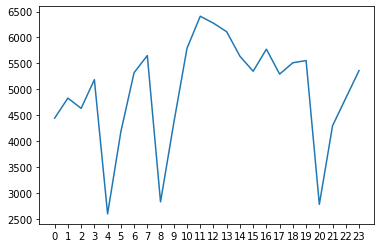

In [ ]:
class_0_plot = class_0.drop(['cycles'], axis=1)
plt.plot(class_0_plot.iloc[32])
plt.plot()
print(class_0_plot.iloc[32])

In [ ]:
class_0=class_0.sample(n=50)
class_1=class_1.sample(n=50)
class_2=class_2.sample(n=50)
class_3=class_3.sample(n=50) 

In [ ]:
dataset = pd.concat([class_0,class_1,class_2,class_3])

In [ ]:
dataset

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,cycles
1016,1178.0,589.00,3201.000,4433.0000,2216.50000,4846.750000,2423.375000,2510.187500,2549.093750,4338.546875,...,5548.492920,4723.746460,4269.873230,4347.936615,4063.468307,3429.734154,3689.367077,3208.683538,2728.0,0
863,3915.0,1957.50,3661.750,1830.8750,915.43750,4319.218750,5485.109375,5697.554688,6059.277344,7108.138672,...,5570.986542,5470.993271,5709.996635,5936.498318,4081.249159,5126.124579,6259.062290,5808.531145,5358.0,0
58,2493.0,1246.50,4314.750,6015.3750,3067.68750,6051.343750,7009.171875,7235.585938,5183.792969,2320.896484,...,4132.764008,4783.882004,5086.941002,5403.470501,5285.735250,4942.867625,5831.433813,4098.216906,2365.0,0
162,6225.0,7316.50,7930.250,8290.6250,4145.31250,6449.656250,7735.828125,7155.914063,3577.957031,6039.978516,...,8193.452789,8172.726395,8046.363197,8142.681599,8080.840799,4040.420400,5725.710200,7035.355100,8345.0,0
496,2398.0,1199.00,3924.000,5244.0000,5880.50000,6433.750000,6711.875000,4565.437500,3342.218750,3923.609375,...,6903.978271,4772.489136,3784.744568,4091.872284,5754.936142,2877.468071,5646.734035,5999.867018,6353.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,71.5,604.25,-113.375,-143.1875,-1063.09375,-3180.046875,-792.023438,799.488281,663.744141,-101.627930,...,-469.041061,-297.520531,-284.260265,-298.130133,-630.065066,-609.032533,-215.016267,130.991867,543.0,3
91,107.5,612.25,-72.375,-179.1875,-1064.09375,-3139.046875,-762.023438,765.488281,641.744141,-86.627930,...,-489.041061,-323.520531,-301.260265,-318.130133,-656.065066,-638.032533,-261.016267,90.991867,512.0,3
91,96.5,504.25,4.625,-269.1875,-1159.09375,-3149.046875,-803.023438,844.488281,700.744141,-82.627930,...,-572.041061,-395.520531,-269.260265,-331.130133,-607.065066,-567.032533,-343.016267,202.991867,664.0,3
91,103.5,541.25,-5.375,-291.1875,-1199.09375,-3028.046875,-757.023438,864.488281,808.744141,-148.627930,...,-564.041061,-391.520531,-212.260265,-286.130133,-634.065066,-514.032533,-318.016267,183.991867,679.0,3


In [ ]:
x=dataset.drop(["cycles"], axis = 1);
y=dataset["cycles"]

In [ ]:
x_train=[]
y_train=[]
x_test=[]
y_test=[]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, shuffle=True )
x_train=x_train.astype('int')
y_train=y_train.astype('int')
x_test=x_test.astype('int')
y_test=y_test.astype('int')

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
rf_clf = RandomForestClassifier(oob_score=True, criterion='entropy',verbose=3)   
rf_clf.fit(x_train,y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
b

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished


RandomForestClassifier(criterion='entropy', oob_score=True, verbose=3)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, precision_score
y_pred = rf_clf.predict(x_test)
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))
print(accuracy_score(y_test, y_pred))
print("Weighted f1_score= ",f1_score(y_test, y_pred,average='weighted'))
print("Weighted precision = ",precision_score(y_test, y_pred, average='weighted'))

[[18  1  1  0]
 [ 2 14  4  0]
 [ 0  1 14  0]
 [ 0  0  0 11]]
              precision    recall  f1-score   support

           0       0.90      0.90      0.90        20
           1       0.88      0.70      0.78        20
           2       0.74      0.93      0.82        15
           3       1.00      1.00      1.00        11

    accuracy                           0.86        66
   macro avg       0.88      0.88      0.88        66
weighted avg       0.87      0.86      0.86        66

0.8636363636363636
Weighted f1_score=  0.8622499504852446
Weighted precision =  0.8720095693779905


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


In [ ]:
import xgboost as xgb
xgb_cl = xgb.XGBClassifier(objective='multi:softmax', early_stopping_rounds=10)
xgb_cl.fit(x_train,y_train,
           verbose=True)

y_pred = xgb_cl.predict(x_test)
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))
print(accuracy_score(y_test, y_pred))
print("Weighted f1_score= ",f1_score(y_test, y_pred,average='weighted'))
print("Weighted precision = ",precision_score(y_test, y_pred, average='weighted'))

[[17  2  0  1]
 [ 2 14  4  0]
 [ 0  3 12  0]
 [ 0  0  0 11]]
              precision    recall  f1-score   support

           0       0.89      0.85      0.87        20
           1       0.74      0.70      0.72        20
           2       0.75      0.80      0.77        15
           3       0.92      1.00      0.96        11

    accuracy                           0.82        66
   macro avg       0.82      0.84      0.83        66
weighted avg       0.82      0.82      0.82        66

0.8181818181818182
Weighted f1_score=  0.8171138507744399
Weighted precision =  0.8176501860712387


In [ ]:
!pip install dtw
import dtw
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from scipy.spatial import distance
def DTW(a, b):   
    an = a.size
    bn = b.size
    pointwise_distance = distance.cdist(a.reshape(-1,1),b.reshape(-1,1))
    cumdist = np.matrix(np.ones((an+1,bn+1)) * np.inf)
    cumdist[0,0] = 0

    for ai in range(an):
        for bi in range(bn):
            minimum_cost = np.min([cumdist[ai, bi+1],
                                   cumdist[ai+1, bi],
                                   cumdist[ai, bi]])
            cumdist[ai+1, bi+1] = pointwise_distance[ai,bi] + minimum_cost

    return cumdist[an, bn]

#train
parameters = {'n_neighbors':[1]}
clf = GridSearchCV(KNeighborsClassifier(metric=DTW), parameters, cv=3, verbose=1)
clf.fit(x_train, y_train)



#evaluate
y_pred = clf.predict(x_test)
print(classification_report(y_test, y_pred))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Fitting 3 folds for each of 1 candidates, totalling 3 fits
              precision    recall  f1-score   support

           0       1.00      0.70      0.82        20
           1       0.70      0.80      0.74        20
           2       0.71      0.80      0.75        15
           3       0.92      1.00      0.96        11

    accuracy                           0.80        66
   macro avg       0.83      0.82      0.82        66
weighted avg       0.83      0.80      0.80        66



In [ ]:
len(class_3.index)

50

In [ ]:
x=dataset.drop(["cycles"], axis = 1);
y=dataset["cycles"]
x_train=[]
y_train=[]
x_test=[]
y_test=[]
x=normalize(x)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, shuffle=True )

x_train=np.array(x_train).astype('float')
y_train=np.array(y_train).astype('float')
x_test=np.array(x_test).astype('float')
y_test=np.array(y_test).astype('float')

In [ ]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(134, 24)
(134,)
(66, 24)
(66,)


In [ ]:
import ee

In [ ]:
!pip install -U geemap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.1 MB 6.8 MB/s 
     |████████████████████████████████| 55 kB 4.2 MB/s 
     |████████████████████████████████| 1.2 MB 42.4 MB/s 
     |████████████████████████████████| 3.7 MB 38.9 MB/s 
     |████████████████████████████████| 8.8 MB 42.6 MB/s 
     |████████████████████████████████| 3.0 MB 32.4 MB/s 
     |████████████████████████████████| 99 kB 10.2 MB/s 
     |████████████████████████████████| 46 kB 4.2 MB/s 
     |████████████████████████████████| 98 kB 8.9 MB/s 
     |████████████████████████████████| 198 kB 55.0 MB/s 
     |████████████████████████████████| 1.3 MB 56.7 MB/s 
     |████████████████████████████████| 130 kB 54.9 MB/s 
     |████████████████████████████████| 128 kB 43.6 MB/s 
     |████████████████████████████████| 1.6 MB 57.6 MB/s 
     |████████████████████████████████| 9.8 MB 35.8 MB/s 
     |████████████████████████████████|

In [ ]:
import geemap
from geemap import ml
from sklearn import ensemble

AttributeError: ignored

In [ ]:
geemap.ee_initialize()

To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://code.earthengine.google.com/client-auth?scopes=https%3A//www.googleapis.com/auth/earthengine%20https%3A//www.googleapis.com/auth/devstorage.full_control&request_id=-BPXzsWMhMyU0yXaBRjWRC4M_RcsUC2y_UEHwTwRc-M&tc=1gprLUBhivdRBaKnxYEObFdyvq_b5wXWxNpTFQP28zg&cc=OueMIdCfserYEZ7s0kFjns1Kj2IXdohT14J4-1-zWwc

The authorization workflow will generate a code, which you should paste in the box below.
Enter verification code: 4/1ARtbsJoZEvCJotbYjQklaaYPn6sVFkZfN9pOv1VaHsvNeN4ab998YHTJSUw

Successfully saved authorization token.


In [ ]:
feature_names = ['nd_p100','nd_p100_1','nd_p100_2','nd_p100_3','nd_p100_4','nd_p100_5','nd_p100_6','nd_p100_7','nd_p100_8','nd_p100_9','nd_p100_10','nd_p100_11','nd_p100_12','nd_p100_13','nd_p100_14','nd_p100_15','nd_p100_16','nd_p100_17','nd_p100_18','nd_p100_19','nd_p100_20','nd_p100_21','nd_p100_22','nd_p100_23']
label = "cycles"

In [ ]:
# convert the estimator into a list of strings
# this function also works with the ensemble.ExtraTrees estimator
trees = ml.rf_to_strings(rf_clf, feature_names)

In [ ]:
# create a ee classifier to use with ee objects from the trees
ee_classifier = ml.strings_to_classifier(trees)

In [ ]:
l8 = ee.Image('projects/ee-g00085636/assets/NDVI_SRI_LANKA_unmasked') #the unmasked image from google earth engine (I converted it into a google earth engine asset first)

In [ ]:
# classify the image using the classifier we created from the local training
# note: here we select the feature_names from the image that way the classifier knows which bands to use
classified = l8.select(feature_names).classify(ee_classifier)

In [ ]:
# display results
Map = geemap.Map(center=(18.6657, 35.5296),zoom=11)

Map.addLayer(
    l8,
    {"bands": ['nd_p100_2','nd_p100_5','nd_p100_7'], "min": -10000, "max": 10000, "gamma": 1.5},
    'image',
)
Map.addLayer(
    classified,
    { "palette": ['#ffffff', '#008000', '#ffff00','#ff0000']},
    'classification',
)
Map

Map(center=[18.6657, 35.5296], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(chi…